# Case Data Master Cientista de Dados

### Tarefa A
a) Um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal. Neste caso, o custo de preparar e executar uma ação de retenção é um valor fixo de RS10 por cliente. Nada é ganho pois a ação de retenção não é capaz de mudar o comportamento do cliente. Um falso negativo ocorre quando um cliente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho. Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (RS100) menos os custos relacionados à ação de retenção ($10). Por fim, um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro.

A primeira tarefa deste case é maximizar o lucro esperado por cliente considerando o contexto descrito no parágrafo acima.


### Tarefa B
b. A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).

### Tarefa C
c. Todo conjunto de dados é passível de ser dividido em grupos coesos, conhecidos como agrupamentos naturais. A terceira tarefa é encontrar os três grupos naturais que possuem os maiores lucros esperados por cliente (usando os mesmos valores da primeira questão).

# Instalações & Importações

In [1]:
## Instalação de Bibliotecas
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install factor_analyzer
!pip install matplotlib
!pip install catboost
!pip install graphviz
!pip install plotly
!pip install six
!pip install shap-selection
!pip install shap-selection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=07f93f68e613b990518545a4be451b58c25d8e09800a9c2fcdf024bc3cd0258a
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [2]:
## Importações

# Bases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

# Utilitarios
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

# UnderSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# FA
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity, FactorAnalyzer

# Avaliação
from sklearn.metrics import average_precision_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Pipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Funções

In [3]:
## Funções Usada

def relatorio(df: pd.DataFrame) -> None:
    """Gera um breve relatório exploratório do DataFrame"""


    print("=" * 70)
    print(f"Número de Colunas: {df.shape[1]:,}")
    print(f"Número de Linhas: {df.shape[0]:,}")
    print("=" * 70)

    # Linhas duplicadas (ignorando ID)
    dup_mask = df.drop(columns=['ID','TARGET'], errors='ignore').duplicated(keep='first')
    print(f"Número de Linhas Duplicadas: {dup_mask.sum():,}")

    # Colunas constantes
    const_cols = [
        c for c in df.columns
        if c != 'ID' and df[c].nunique(dropna=False) == 1
    ]
    print(f"Número de Colunas Constantes: {len(const_cols):,}")

    # Colunas idênticas (Aprofundar o Conceitual)
    col_hashes = df.apply(lambda col: hash(tuple(col)), axis=0)
    num_identicas = col_hashes.duplicated().sum()
    print(f"Número de Colunas Idênticas: {num_identicas:,}")

    print("=" * 70)

    # Valores nulos
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0].sort_values(ascending=False)
    print(f"Colunas com Valores Nulos: {len(nulls):,}")

    print("=" * 70)

    # Distribuição da variável TARGET
    if 'TARGET' in df.columns:
        target_0 = (df['TARGET'] == 0).sum()
        target_1 = (df['TARGET'] == 1).sum()
        total = len(df)

        print(f"TARGET = 0 (Insatisfeitos): {target_0:,} ({target_0 / total:.1%})")
        print(f"TARGET = 1 (Satisfeitos): {target_1:,} ({target_1 / total:.1%})")
        print(f"Total de clientes: {total:,}")
    else:
        print("Coluna TARGET não encontrada.")

    print("=" * 70)


def pre_processamento(df: pd.DataFrame) -> pd.DataFrame:
    """Remove duplicatas, colunas constantes, colunas idênticas,
       features com variância zero e correlação perfeita"""

    relatorio(df)
    print("=" * 70)

    # linhas duplicadas
    dup_mask = df.drop(columns=['ID','TARGET'], errors='ignore').duplicated(keep='first')
    df = df.loc[~dup_mask].reset_index(drop=True)
    print(f"{dup_mask.sum():,} Linhas Duplicadas Removidas!")

    # Colunas constantes
    const_cols = [
        c for c in df.columns
        if c != 'ID' and df[c].nunique(dropna=False) == 1
    ]
    df = df.drop(columns=const_cols)
    print(f"{len(const_cols):,} Colunas Constantes Removidas!")

    # Colunas idênticas
    col_hashes = df.apply(lambda col: hash(tuple(col)), axis=0)
    duplicated_cols = col_hashes.duplicated()
    num_identicas = duplicated_cols.sum()

    df = df.loc[:, ~duplicated_cols]
    print(f"{num_identicas:,} Colunas Idênticas Removidas!")


    # variância zero
    features = df.drop(columns=["ID", "TARGET"], errors='ignore')

    # Apenas numéricas
    features_num = features.select_dtypes(include='number')

    var_zero = features_num.var()
    var_zero = var_zero[var_zero == 0]

    print("=" * 70)
    print("Features com Variância Zero:")
    print(var_zero)
    print("=" * 70)

    df = df.drop(columns=var_zero.index)
    print(f"{len(var_zero):,} Features com Variância Zero Removidas!")

    # Correlação perfeita
    features_clean = df.drop(columns=["ID", "TARGET"], errors='ignore')
    features_clean = features_clean.select_dtypes(include='number')

    corr_matrix = features_clean.corr().abs()

    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = [col for col in upper.columns if any(upper[col] == 1)]

    df = df.drop(columns=to_drop)
    print(f"{len(to_drop):,} Features com Correlação Perfeita Removidas!")

    print("=" * 70)

    return df

def calcula_prevalencia(y_actual):
    '''
    Calcula e exibe a prevalência da classe positiva em um conjunto de rótulos reais.
    '''
    print(f'Prevalência da classe não nula (1): {sum(y_actual) * 100/ len(y_actual):.3f}%')


def calcula_valores_validos(df):
    '''
    Calcula e exibe a porcentagem de valores nulos ou faltantes em cada coluna do DataFrame apenas se existirem.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    valores_exibidos = 0
    for col in df.columns:
        soma_nulos = sum(df[col].isnull() | df[col].isna())
        if soma_nulos > 0 :
            print(f'Valores Nulos em {col}: {soma_nulos * 100/ len(df[col]):.3f}%')
            valores_exibidos += 1
    if valores_exibidos == 0:
        print('Nenhum valor nulo ou faltante encontrado no DataFrame.')


def verifica_balanceamento(df, coluna_alvo):
    '''
    Verifica o balanceamento das classes em uma coluna alvo de um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    coluna_alvo (str): O nome da coluna alvo que contém as classes.
    '''
    contagem_classes = df[coluna_alvo].value_counts()
    proporcao_classes = df[coluna_alvo].value_counts(normalize=True) * 100
    balanceamento = pd.DataFrame({'Contagem': contagem_classes, 'Proporção (%)': np.round(proporcao_classes, 2)})
    print(balanceamento)


def verifica_coluna_constante(df):
    '''
    Verifica se há colunas constantes (com o mesmo valor em todas as linhas) em um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    colunas_constantes = [col for col in df.columns if df[col].nunique() == 1]
    if colunas_constantes:
        print(f'Colunas constantes encontradas: {colunas_constantes}')
    else:
        print('Nenhuma coluna constante encontrada.')


def threshold_otimizado_f1(y_true, y_prob, n_thresholds=100):
    """
    Encontra o threshold que maximiza o F1-score.
    """
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    best_f1 = -1
    best_threshold = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


# def validacao_cruzada(
#     modelo,
#     X,
#     y,
#     metric,
#     oversampler=None,
#     n_splits=5,
#     shuffle=False,
#     prediction_method="predict_proba",
#     random_state=None
# ):

#     skf = StratifiedKFold(
#         n_splits=n_splits,
#         shuffle=shuffle,
#         random_state=random_state
#     )

#     scores = []

#     for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
#         # Clona modelo (CRÍTICO)
#         modelo_fold = clone(modelo)

#         X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
#         X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
#         y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
#         y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

#         # Oversampling só no treino
#         if oversampler:
#             X_train, y_train = oversampler.fit_resample(X_train, y_train)

#         modelo_fold.fit(X_train, y_train)

#         if prediction_method == "predict_proba":
#             y_pred = modelo_fold.predict_proba(X_test)[:, 1]
#         elif prediction_method == "predict":
#             y_pred = modelo_fold.predict(X_test)
#         else:
#             raise ValueError("prediction_method deve ser 'predict' ou 'predict_proba'")

#         score = metric(y_test, y_pred)
#         scores.append(score)

#         print(f"Fold {fold + 1}: {metric.__name__} = {score:.4f}")

#     print(f"\nScore médio: {np.mean(scores):.4f}")
#     print(f"Desvio padrão: {np.std(scores):.4f}")

#     return scores

def validacao_cruzada(
    modelo,
    X,
    y,
    metric,
    oversampler=None,
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada com threshold otimizado para F1-score.
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    scores = []
    thresholds_otimos = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Probabilidade da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # Threshold ótimo + F1
        best_threshold, best_f1 = threshold_otimizado_f1(y_test, y_prob)

        scores.append(best_f1)
        thresholds_otimos.append(best_threshold)

        print(
            f"Fold {fold}: "
            f"F1 = {best_f1:.4f} | "
            f"Threshold ótimo = {best_threshold:.2f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"F1 médio: {np.mean(scores):.4f}")
    print(f"Desvio padrão F1: {np.std(scores):.4f}")
    print(f"Threshold médio: {np.mean(thresholds_otimos):.2f}")

    return {
        "f1_scores": scores,
        "thresholds": thresholds_otimos
    }


## Importação de Arquivos

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ArquivosSantander/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ArquivosSantander/test.csv")

# Análise Exploratória

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
df_train.info()

In [ ]:
relatorio(df_test)

In [ ]:
sns.countplot(x='TARGET', data=df_train)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.show()

In [ ]:
verifica_balanceamento(df_train,'TARGET')
calcula_valores_validos(df_train)

In [ ]:
relatorio(df_train)

In [ ]:
df_train = pre_processamento(df_train)
# df_test = pre_processamento(df_test)

## Corelação

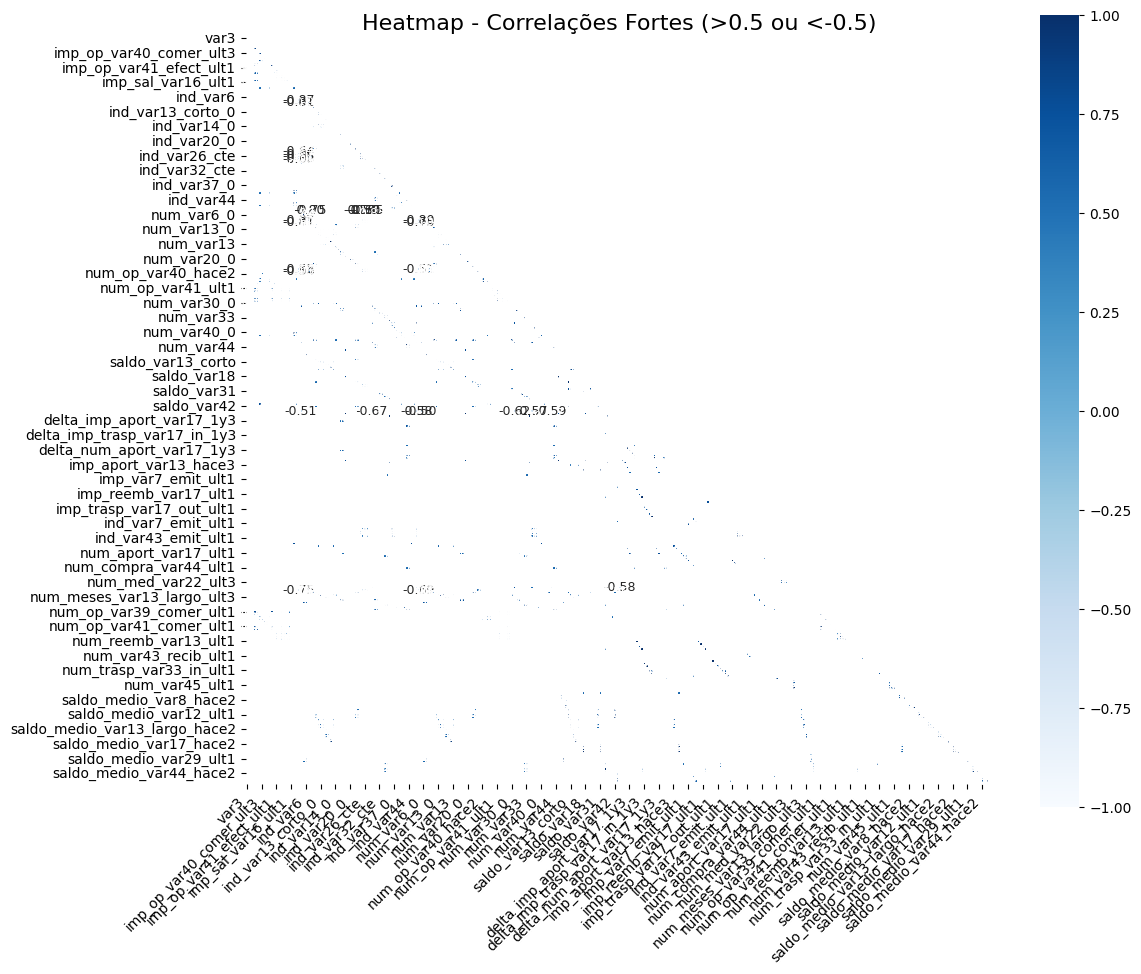

In [ ]:
corr_matrix = df_train.drop(columns=['TARGET', 'ID']).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
strong_corr = corr_matrix.mask(np.abs(corr_matrix) <= 0.5)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    strong_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 9},
    vmin=-1, vmax=1
)

plt.title("Heatmap - Correlações Fortes (>0.5 ou <-0.5)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Matriz de correlação
corr_matrix = df_train.drop(columns=['TARGET', 'ID']).corr()

# Máscara para metade superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Filtrar correlações fortes
strong_corr = corr_matrix.where(np.abs(corr_matrix) > 0.5, np.nan)

# Ajuste de tamanho dinâmico
plt.figure(figsize=(corr_matrix.shape[1]*0.5, corr_matrix.shape[1]*0.5))

# Heatmap
sns.heatmap(
    strong_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    cbar_kws={'shrink': 0.7, 'label': 'Correlação'},
    linewidths=0.5,
    annot_kws={"size": 8},
    vmin=-1,
    vmax=1
)

plt.title("Heatmap - Correlações Fortes (>0.5 ou <-0.5)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


# PCA

In [ ]:
df_train_scaled = StandardScaler().fit_transform(df_train.drop(columns=['ID', 'TARGET']))
df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_train.drop(columns=['ID', 'TARGET']).columns)

df_train_scaled = pd.concat([df_train['TARGET'], df_train_scaled, df_train['ID']], axis=1)

In [ ]:
df_train_scaled.head()

In [ ]:
df_train_pca = df_train_scaled.drop(columns=['ID', 'TARGET'])

pca = PCA()
pca.fit_transform(df_train_pca)

# Variância Acumlada
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# Análise Eigenvalues (Critério de Kaiser e Análise de Cotovelo)
eigenvalues = pca.explained_variance_

eigenvalues_kaiser = eigenvalues[eigenvalues > 1]
n_componentes_kaiser = len(eigenvalues_kaiser)

# Plotar até o dobro do número de componentes indicado pelo critério de Kaiser
n_componentes_kaiser_plot = int(n_componentes_kaiser * 1.5)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=eigenvalues[0:n_componentes_kaiser_plot])

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=f"Critério de Kaiser (λ = 1) : {n_componentes_kaiser} componentes"
)

plt.axhline(
    y=1,
    color="red",
    linestyle="--"
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)
plt.title("Variância Explicada por Autovetor")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada")
plt.show()

print(f"Número de componentes pelo critério de Kaiser: {n_componentes_kaiser}")

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=cum_var_exp[:n_componentes_kaiser_plot],
    marker='o'
)

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=(
        f"Kaiser: {n_componentes_kaiser} componentes "
        f"({cum_var_exp[n_componentes_kaiser - 1]:.1%} variância acumulada)"
    )
)

# Linha de referência (ex: 90%)
plt.axhline(
    y=0.9,
    color='gray',
    linestyle='--',
    label='90% Variância Explicada'
)

plt.title("Variância Explicada Acumulada (Análise do Cotovelo)")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)

plt.tight_layout()
plt.show()


Como parece não haver um "cotovelo" bem definido, vamos usar o critério de kaiser matendo aproxidamente 87,2% da variância acumulada com 67 PC´s

In [ ]:
pca_kaiser = PCA(n_components=n_componentes_kaiser)
X_pca_kaiser = pca_kaiser.fit_transform(df_train_pca)

df_pca_kaiser = pd.concat(
    [ df_train['ID'],
      pd.DataFrame(X_pca_kaiser, columns=[f'PC_{i+1}' for i in range(n_componentes_kaiser)]),
      df_train['TARGET']
      ],
    axis=1
    )

In [ ]:
df_pca_kaiser.head()

In [ ]:
verifica_balanceamento(df_pca_kaiser, 'TARGET')
calcula_valores_validos(df_pca_kaiser)

# Criação das Funções para a Pipeline

A utilização da classe Pipeline do pacote sklearn requer que os steps sejam classes que herdem de BaseEstimator e TransformerMixin. Por isso, criamos as classes abaixo:

In [ ]:
class PipeSteps(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

# Primeira Validação Cruzada

In [ ]:
# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Pipeline do scikit-learn
from sklearn.pipeline import Pipeline

# Métricas (caso queira usar F1 score)
from sklearn.metrics import f1_score

from sklearn.base import clone

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)
xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    scale_pos_weight=(df_pca_kaiser['TARGET'] == 0).sum() / (df_pca_kaiser['TARGET'] == 1).sum(),
    random_state=42
)
rf = RandomForestClassifier(
    n_estimators=150,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

score_modelos = {}
pipelines = {}
for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        # ('preprocessing', pipe_prepropcessamento),
        ('classifier', modelo)
    ])
    print(f'Pipeline para {nome_modelo} criada com sucesso.')
    # print(pipelines[nome_modelo])
    print()  # Linha em branco para melhor legibilidade

    # Treinamento com validação cruzada (F1 com threshold otimizado)
    print(f'Validação Cruzada para {nome_modelo}:')

    score_modelos[nome_modelo] = validacao_cruzada(
        modelo=pipelines[nome_modelo],
        X=df_pca_kaiser.drop(['ID', 'TARGET'], axis=1),
        y=df_pca_kaiser['TARGET'],
        metric=f1_score,
        oversampler=None,
        n_splits=5,
        shuffle=True,
        random_state=42  # Threshold será otimizado internamente
    )

    print('-' * 50)

# Modelos
Obs: 1º, 3º e 4º atingiram 0.29 de F1-Score, melhor até agora no X_test, vou rodar eles com o df_test

## 1B - FA Only + SFM

Classificador
Estive Pensando, a segunda tarefa consiste em uma avaliação de risco dando notas de 1-5, sendo que apenas o grupo com risco 1 recebe a ação...

In [ ]:
## 1B - FA Only + SFM
# Splits
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Remoção de Colunas Constantes
vt = VarianceThreshold(0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train), # fit_transform em X_treino
    columns=X_train.columns[vt.get_support()]
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test), # transform em X_test
    columns=X_train.columns[vt.get_support()]
)

# Seleção de Features Base
print("Seleção de Features Base")
sfm_base = SelectFromModel( # Criação do Objeto
    CatBoostClassifier(
        iterations=2000,
        loss_function='Logloss',
        eval_metric='F1',
        verbose=1000,
        random_state=42
    ),
    threshold='median' # Eliminar os que tem importância menor que a mediana
)

# Treinamento para realizar a Seleção Priorizando F1
sfm_base.fit(X_train_vt, y_train)

# Real Seleção
X_train_sel = pd.DataFrame(
    sfm_base.transform(X_train_vt), # Apenas os Selecionados pelo objeto
    columns=X_train_vt.columns[sfm_base.get_support()]
)

X_test_sel = pd.DataFrame(
    sfm_base.transform(X_test_vt),
    columns=X_train_sel.columns
)

# Treinamento com as Selecionadas
print("\nTreinamento com as Selecionadas por Importância")
cat_base = CatBoostClassifier(
    iterations=6000,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=1000,
    random_state=42
)

cat_base.fit(X_train_sel, y_train)

# FA
# FA com as Features que representam 90% das mais Importantes para o Segundo Modelo (pós-primeira seleção)
print("\nFA com as Features que representam 90% das mais Importantes para o Segundo Modelo (pós-primeira seleção)")
df_imp = cat_base.get_feature_importance(prettified=True)

cum_imp = np.cumsum(df_imp['Importances'])
norm_imp = cum_imp / cum_imp.values[-1]

idx_90 = np.where(norm_imp >= 0.9)[0][0]

features_90 = (
    df_imp.sort_values(by='Importances', ascending=False)
    .iloc[:idx_90]['Feature Id']
    .tolist()
)

# Análise Fatorial
X_fa = X_train_sel[features_90]

fa = FactorAnalyzer(n_factors=8, rotation='varimax')
fa.fit(X_fa)

loadings = pd.DataFrame(
    fa.loadings_,
    index=X_fa.columns,
    columns=[f'Factor_{i+1}' for i in range(8)]
)

# Mapa das Features por Fator
factor_map = {}

for fact in loadings.columns:
    feats = loadings.loc[loadings[fact].abs() > 0.4, fact].index.tolist()
    factor_map[fact] = feats

# =========================
# 7) FUNÇÃO DE AGREGAÇÃO (TRAIN / TEST)
# =========================
def build_fa_aggregated_features(X_input, factor_map):
    X_out = pd.DataFrame(index=X_input.index)

    for fact, feats in factor_map.items():
        feats = [f for f in feats if f in X_input.columns]
        if len(feats) < 2:
            continue

        X_out[f'{fact}_mean']   = X_input[feats].mean(axis=1)
        X_out[f'{fact}_sum']    = X_input[feats].sum(axis=1)
        X_out[f'{fact}_max']    = X_input[feats].max(axis=1)
        X_out[f'{fact}_min']    = X_input[feats].min(axis=1)
        X_out[f'{fact}_std']    = X_input[feats].std(axis=1)
        X_out[f'{fact}_active'] = (X_input[feats] > 0).sum(axis=1)

    return X_out

X_train_fa = build_fa_aggregated_features(X_train_sel[features_90], factor_map)
X_test_fa  = build_fa_aggregated_features(X_test_sel[features_90], factor_map)

# Garantir alinhamento
X_test_fa = X_test_fa.reindex(columns=X_train_fa.columns, fill_value=0)


# Seleção Final com Feature Eng. Informada
sfm_final = SelectFromModel(
    CatBoostClassifier(
        iterations=6000,
        loss_function='Logloss',
        eval_metric='F1',
        verbose=1000,
        random_state=42
    ),
    threshold='median'
)

print("\nSeleção Final com Feature Eng. Informada")
sfm_final.fit(X_train_fa, y_train)

X_train_final = pd.DataFrame(
    sfm_final.transform(X_train_fa),
    columns=X_train_fa.columns[sfm_final.get_support()]
)

X_test_final = pd.DataFrame(
    sfm_final.transform(X_test_fa),
    columns=X_train_final.columns
)

# Modelo Final
cat_final = CatBoostClassifier(
    iterations=6000,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=1000,
    random_state=42
)

print("\nTreino Final")
cat_final.fit(X_train_final, y_train)

y_pred = cat_final.predict(X_test_final)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
## Avaliação
# Features Selecionadas Final
selected_features = X_train_fa.columns[sfm_final.get_support()]

print(f"Número de features selecionadas: {len(selected_features)}")
print(selected_features.tolist())

# Otimização de Threshold
y_prob = cat_final.predict_proba(X_test_final)[:, 1]

thresholds = np.linspace(0.01, 0.5, 100)
f1_scores = [f1_score(y_test, y_prob >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_t = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nMelhor threshold: {best_t:.3f}")
print(f"\nMelhor F1: {best_f1:.4f}")

# =========================
# AVALIAÇÃO FINAL
# =========================
y_pred_opt = (y_prob >= best_t).astype(int)

print("\nClassification Report (threshold otimizado)")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm_opt.ravel()

print("\nConfusion Matrix (ótimo)")
print(cm_opt)
print(f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")

## 2B - CB + Eliminição p/ Importância

In [ ]:
## 2B - CB + Eliminição p/ Importância
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()]
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")

# Modelo de ranking (sem seleção ainda)
rank_model = CatBoostClassifier(
    iterations=2000,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=False,
    random_state=42
)

rank_model.fit(X_train_vt, y_train)


# Seleção supervisionada por importância
importances = rank_model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_vt.columns)

# Corte técnico: TOP 30%
TOP_PCT = 0.30
n_features = int(TOP_PCT * len(feat_imp))

selected_features = (
    feat_imp
    .sort_values(ascending=False)
    .iloc[:n_features]
    .index
)

print(f"Features selecionadas (TOP {int(TOP_PCT*100)}%): {len(selected_features)}")

X_train_sel = X_train_vt[selected_features]
X_test_sel = X_test_vt[selected_features]

final_model = CatBoostClassifier(
    iterations=6000,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=False,
    random_state=42
)

final_model.fit(X_train_sel, y_train)

y_prob = final_model.predict_proba(X_test_sel)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("\n=== Classification Report (threshold = 0.5) ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix")
print(cm)
print(f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")


# Otimização de threshold (F1 da classe 1)
thresholds = np.linspace(0.05, 0.5, 100)
f1_scores = [f1_score(y_test, y_prob >= t) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"\nBest threshold: {best_t:.3f}")
print(f"Best F1: {best_f1:.4f}")

# Avaliação com threshold otimizado
y_pred_opt = (y_prob >= best_t).astype(int)

print("\n=== Classification Report (threshold otimizado) ===")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm_opt.ravel()

print("\nConfusion Matrix (Threshold otimizado)")
print(cm_opt)
print(f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")

# Melhor Modelo: 2B... Avanço

In [ ]:
## 2B - CB + Eliminição p/ Importância + Avanço
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()]
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")

# Modelo de ranking (sem seleção ainda)
rank_model = CatBoostClassifier(
    iterations=2000,
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=False,
    random_state=42
)

rank_model.fit(X_train_vt, y_train)


# Seleção supervisionada por importância
importances = rank_model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_vt.columns)

# Corte técnico: TOP 30%
TOP_PCT = 0.30
n_features = int(TOP_PCT * len(feat_imp))

selected_features = (
    feat_imp
    .sort_values(ascending=False)
    .iloc[:n_features]
    .index
)

print(f"Features selecionadas (TOP {int(TOP_PCT*100)}%): {len(selected_features)}")

X_train_sel = X_train_vt[selected_features]
X_test_sel = X_test_vt[selected_features]

final_model = CatBoostClassifier(
    iterations=6000,
    loss_function='Logloss',
    eval_metric='Logloss', # Métrica alterada
    verbose=False,
    random_state=42
)

final_model.fit(X_train_sel, y_train)

y_prob = final_model.predict_proba(X_test_sel)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("\n=== Classification Report (threshold = 0.5) ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix")
print(cm)
print(f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")


# Otimização de threshold (F1 da classe 1)
thresholds = np.linspace(0.05, 0.5, 100)
f1_scores = [f1_score(y_test, y_prob >= t) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

###
profits = [
    (90 * np.sum(
        (y_prob >= t) & (y_test == 1)
        )
   - 10 * np.sum((y_prob >= t) & (y_test == 0)))
    for t in thresholds
]

best_t = thresholds[np.argmax(profits)]

print(f"\nBest threshold: {best_t:.3f}")

# Avaliação com threshold otimizado
y_pred_opt = (y_prob >= best_t).astype(int)

print("\n=== Classification Report (threshold otimizado) ===")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm_opt.ravel()

print("\nConfusion Matrix (Threshold otimizado)")
print(cm_opt)
print(f"TN={tn} | FP={fp} | FN={fn} | TP={tp}")

Features após VarianceThreshold: 305
Features selecionadas (TOP 30%): 91

=== Classification Report (threshold = 0.5) ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     20510
           1       0.45      0.01      0.01       814

    accuracy                           0.96     21324
   macro avg       0.71      0.50      0.50     21324
weighted avg       0.94      0.96      0.94     21324


Confusion Matrix
[[20504     6]
 [  809     5]]
TN=20504 | FP=6 | FN=809 | TP=5

Best threshold: 0.077

=== Classification Report (threshold otimizado) ===
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     20510
           1       0.17      0.59      0.26       814

    accuracy                           0.87     21324
   macro avg       0.58      0.74      0.60     21324
weighted avg       0.95      0.87      0.91     21324


Confusion Matrix (Threshold otimizado)
[[18144  2366]
 [  334   48

# Melhor Lucro Médio + Teste de Diferentes Padrões de Treinamento

In [ ]:
# Com Shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# ============================================================
# Função de otimização por LUCRO MÉDIO
# ============================================================
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    """
    Retorna o threshold que maximiza o LUCRO MÉDIO POR CLIENTE
    """
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred_opt = (y_prob >= best_t).astype(int)
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp} ")

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio,
        'cm': cm
    }


# ============================================================
# 1) Split
# ============================================================
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# ============================================================
# 2) Variance Threshold
# ============================================================
vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()],
    index=X_train.index
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns,
    index=X_test.index
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# ============================================================
# 3) Modelo de ranking (SHAP)
# ============================================================
rank_model = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Recall',
    random_state=42,
    verbose=False
)

rank_model.fit(X_train_vt, y_train)


# --------------------
# SHAP (CORRETO)
# --------------------
X_shap = X_train_vt.sample(
    min(5000, len(X_train_vt)),
    random_state=42
)

shap_pool = Pool(X_shap)

shap_values = rank_model.get_feature_importance(
    type='ShapValues',
    data=shap_pool
)

# Remove coluna do bias
shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

feat_imp = (
    pd.Series(shap_mean, index=X_train_vt.columns)
    .sort_values(ascending=False)
)


# ============================================================
# 4) Loop de cortes + modelo final
# ============================================================
resultados = []
cortes = np.linspace(0.01, 0.6, 12)

for corte in cortes:
    n_features = max(1, int(corte * len(feat_imp)))
    selected_features = feat_imp.iloc[:n_features].index

    X_train_sel = X_train_vt[selected_features]
    X_test_sel = X_test_vt[selected_features]

    final_model = CatBoostClassifier(
        iterations=4000,
        depth=6,
        learning_rate=0.03,
        loss_function='Logloss',
        eval_metric='Recall',
        l2_leaf_reg=10,
        min_data_in_leaf=100,
        subsample=0.8,
        random_state=42,
        verbose=False
    )

    final_model.fit(X_train_sel, y_train)

    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    thresholds = np.linspace(0.01, 0.3, 200)
    res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

    resultados.append({
        'corte': corte,
        'n_features': n_features,
        **res
    })

    print(
        f"Corte: {corte:.2%} | "
        f"Features: {n_features} | "
        f"Lucro médio: R$ {res['lucro_medio']:.4f} | "
        f"TP={res['tp']} FP={res['fp']} | "
        f"Threshold={res['best_threshold']:.3f}"
    )


# ============================================================
# 5) Resultado final
# ============================================================
df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values(
    by='lucro_medio',
    ascending=False
)[[
    'corte',
    'n_features',
    'best_threshold',
    'tp',
    'fp',
    'lucro_total',
    'lucro_medio'
]]

df_resultados


Features após VarianceThreshold: 305


KeyboardInterrupt: 

In [ ]:
b_df = df_resultados.copy()

In [ ]:
b_df

In [ ]:
df_resultados

In [ ]:
# Com Shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# Função de otimização por LUCRO MÉDIO
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    """
    Retorna o threshold que maximiza o LUCRO MÉDIO POR CLIENTE
    """
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred_opt = (y_prob >= best_t).astype(int)
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp} ")

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio,
        'cm': cm
    }


# Split
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# Variance Threshold
vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()],
    index=X_train.index
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns,
    index=X_test.index
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# Modelo de ranking (SHAP)
rank_model = CatBoostClassifier(
    iterations=2000,
    #depth=6,
    #learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Recall',
    random_state=42,
    verbose=False
)

rank_model.fit(X_train_vt, y_train)


# SHAP
X_shap = X_train_vt.sample(
    min(5000, len(X_train_vt)),
    random_state=42
)

shap_pool = Pool(X_shap)

shap_values = rank_model.get_feature_importance(
    type='ShapValues',
    data=shap_pool
)

# Remove coluna do bias
shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

feat_imp = (
    pd.Series(shap_mean, index=X_train_vt.columns)
    .sort_values(ascending=False)
)


# Loop de cortes + modelo final
resultados = []
cortes = np.linspace(0.15, 0.22, 3)

for corte in cortes:
    n_features = max(1, int(corte * len(feat_imp)))
    selected_features = feat_imp.iloc[:n_features].index

    X_train_sel = X_train_vt[selected_features]
    X_test_sel = X_test_vt[selected_features]

    final_model = CatBoostClassifier(
        iterations=4000,
        #depth=6,
        #learning_rate=0.03,
        loss_function='Logloss',
        eval_metric='Recall',
        #l2_leaf_reg=10,
        #min_data_in_leaf=100,
        #subsample=0.8,
        random_state=42,
        verbose=400
    )

    final_model.fit(X_train_sel, y_train)

    y_prob = final_model.predict_proba(X_test_sel)[:, 1]

    thresholds = np.linspace(0.01, 0.3, 200)
    res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

    resultados.append({
        'corte': corte,
        'n_features': n_features,
        **res
    })

    print(
        f"Corte: {corte:.2%} | "
        f"Features: {n_features} | "
        f"Lucro médio: R$ {res['lucro_medio']:.4f} | "
        f"TP={res['tp']} FP={res['fp']} | "
        f"Threshold={res['best_threshold']:.3f}"
    )



# Resultado final

df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values(
    by='lucro_medio',
    ascending=False
)[[
    'corte',
    'n_features',
    'best_threshold',
    'tp',
    'fp',
    'lucro_total',
    'lucro_medio'
]]

df_resultados


In [ ]:
final_model.get_feature_importance(prettified=True)

In [ ]:
importances = final_model.get_feature_importance(prettified=True)

In [ ]:
## Treino só com o Ótimo e class_wight
# Com Shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# Função de otimização por LUCRO MÉDIO
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    """
    Retorna o threshold que maximiza o LUCRO MÉDIO POR CLIENTE
    """
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred_opt = (y_prob >= best_t).astype(int)
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp} ")

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio,
        'cm': cm
    }


# Split
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# Variance Threshold
vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()],
    index=X_train.index
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns,
    index=X_test.index
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# Modelo de ranking (SHAP)
rank_model = CatBoostClassifier(
    iterations=2000,
    #depth=6,
    #learning_rate=0.05,
    #loss_function='Logloss',
    class_weights = {0: 1, 1: 9},
    eval_metric='Recall',
    random_state=42,
    verbose=1000
)

rank_model.fit(X_train_vt, y_train)


# SHAP
X_shap = X_train_vt.sample(
    min(5000, len(X_train_vt)),
    random_state=42
)

shap_pool = Pool(X_shap)

shap_values = rank_model.get_feature_importance(
    type='ShapValues',
    data=shap_pool
)

# Remove coluna do bias
shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

feat_imp = (
    pd.Series(shap_mean, index=X_train_vt.columns)
    .sort_values(ascending=False)
)


# Modelo final
corte = 0.22 # Corte Final

n_features = max(1, int(corte * len(feat_imp)))
selected_features = feat_imp.iloc[:n_features].index

X_train_sel = X_train_vt[selected_features]
X_test_sel = X_test_vt[selected_features]

final_model = CatBoostClassifier(
        iterations=4000,
        #depth=6,
        #learning_rate=0.03,
        loss_function='Logloss',
        class_weights = {0: 1, 1: 9},
        eval_metric='Recall',
        #l2_leaf_reg=10,
        #min_data_in_leaf=100,
        #subsample=0.8,
        random_state=42,
        verbose=1000
    )

final_model.fit(X_train_sel, y_train)

y_prob = final_model.predict_proba(X_test_sel)[:, 1]

thresholds = np.linspace(0.01, 0.3, 200)
res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

print(
    f"Corte: {corte:.2%} | "
    f"Features: {n_features} | "
    f"Lucro médio: R$ {res['lucro_medio']:.4f} | "
    f"TP={res['tp']} FP={res['fp']} | "
    f"Threshold={res['best_threshold']:.3f}"
)

# Resultado final
df_resultados = pd.DataFrame(resultados)

In [ ]:
## Sem weights
# Com Shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# Função de otimização por LUCRO MÉDIO
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    """
    Retorna o threshold que maximiza o LUCRO MÉDIO POR CLIENTE
    """
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred_opt = (y_prob >= best_t).astype(int)
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp} ")

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio,
        'cm': cm
    }


# Split
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# Variance Threshold
vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()],
    index=X_train.index
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns,
    index=X_test.index
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# Modelo de ranking (SHAP)
rank_model = CatBoostClassifier(
    iterations=2000,
    #depth=6,
    #learning_rate=0.05,
    #loss_function='Logloss',
    #class_weights = {0: 1, 1: 9},
    eval_metric='Recall',
    random_state=42,
    verbose=1000
)

rank_model.fit(X_train_vt, y_train)


# SHAP
X_shap = X_train_vt.sample(
    min(5000, len(X_train_vt)),
    random_state=42
)

shap_pool = Pool(X_shap)

shap_values = rank_model.get_feature_importance(
    type='ShapValues',
    data=shap_pool
)

# Remove coluna do bias
shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

feat_imp = (
    pd.Series(shap_mean, index=X_train_vt.columns)
    .sort_values(ascending=False)
)


# Modelo final
corte = 0.22 # Corte Final

n_features = max(1, int(corte * len(feat_imp)))
selected_features = feat_imp.iloc[:n_features].index

X_train_sel = X_train_vt[selected_features]
X_test_sel = X_test_vt[selected_features]

final_model = CatBoostClassifier(
        iterations=4000,
        #depth=6,
        #learning_rate=0.03,
        loss_function='Logloss',
        #class_weights = {0: 1, 1: 9},
        eval_metric='Recall',
        #l2_leaf_reg=10,
        #min_data_in_leaf=100,
        #subsample=0.8,
        random_state=42,
        verbose=1000
    )

final_model.fit(X_train_sel, y_train)

y_prob = final_model.predict_proba(X_test_sel)[:, 1]

thresholds = np.linspace(0.01, 0.3, 200)
res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

print(
    f"Corte: {corte:.2%} | "
    f"Features: {n_features} | "
    f"Lucro médio: R$ {res['lucro_medio']:.4f} | "
    f"TP={res['tp']} FP={res['fp']} | "
    f"Threshold={res['best_threshold']:.3f}"
)

# Resultado final
df_resultados = pd.DataFrame(resultados)

In [ ]:
## Sem weights
# Com Shap
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


def lucro_top_k(y_prob, y_test, k_frac):
    k = int(len(y_prob) * k_frac)

    idx = np.argsort(y_prob)[::-1][:k]
    y_pred = np.zeros(len(y_prob), dtype=int)
    y_pred[idx] = 1

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'k_frac': k_frac,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio
    }


# Split
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# Variance Threshold
vt = VarianceThreshold(threshold=0)

X_train_vt = pd.DataFrame(
    vt.fit_transform(X_train),
    columns=X_train.columns[vt.get_support()],
    index=X_train.index
)

X_test_vt = pd.DataFrame(
    vt.transform(X_test),
    columns=X_train_vt.columns,
    index=X_test.index
)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# Modelo de ranking (SHAP)
rank_model = CatBoostClassifier(
    iterations=2000,
    #depth=6,
    #learning_rate=0.05,
    #loss_function='Logloss',
    #class_weights = {0: 1, 1: 9},
    eval_metric='Recall',
    random_state=42,
    verbose=1000
)

rank_model.fit(X_train_vt, y_train)


# SHAP
X_shap = X_train_vt.sample(
    min(5000, len(X_train_vt)),
    random_state=42
)

shap_pool = Pool(X_shap)

shap_values = rank_model.get_feature_importance(
    type='ShapValues',
    data=shap_pool
)

# Remove coluna do bias
shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

feat_imp = (
    pd.Series(shap_mean, index=X_train_vt.columns)
    .sort_values(ascending=False)
)


# Modelo final
corte = 0.22 # Corte Final

n_features = max(1, int(corte * len(feat_imp)))
selected_features = feat_imp.iloc[:n_features].index

X_train_sel = X_train_vt[selected_features]
X_test_sel = X_test_vt[selected_features]

final_model = CatBoostClassifier(
        iterations=4000,
        #depth=6,
        #learning_rate=0.03,
        loss_function='Logloss',
        #class_weights = {0: 1, 1: 9},
        eval_metric='Recall',
        #l2_leaf_reg=10,
        #min_data_in_leaf=100,
        #subsample=0.8,
        random_state=42,
        verbose=1000
    )

final_model.fit(X_train_sel, y_train)

y_prob = final_model.predict_proba(X_test_sel)[:, 1]

thresholds = np.linspace(0.01, 0.3, 200)

for k in [0.05, 0.10, 0.15, 0.20, 0.25]:
    res = lucro_top_k(y_prob, y_test, k)
    print(res)

# Resultado final
df_resultados = pd.DataFrame(resultados)

# PCA + CatBost + Diferentes PCT´s

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier


# ============================================================
# Função de otimização por LUCRO MÉDIO
# ============================================================
def otimizacao_lucro_medio(y_prob, y_test, thresholds):

    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred = (y_prob >= best_t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio
    }


# ============================================================
# 1) Split
# ============================================================
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# ============================================================
# 2) Variance Threshold
# ============================================================
vt = VarianceThreshold(0)

X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# ============================================================
# 3) Loop APENAS de PCA
# ============================================================
pcs_list = [5, 10, 20, 30, 50, 80, 120]

resultados = []

for n_pcs in pcs_list:

    print(f"\n========== PCA: {n_pcs} componentes ==========")

    scaler = StandardScaler()
    pca = PCA(n_components=n_pcs, random_state=42)

    X_train_pca = pca.fit_transform(
        scaler.fit_transform(X_train_vt)
    )

    X_test_pca = pca.transform(
        scaler.transform(X_test_vt)
    )

    # ========================================================
    # Modelo FINAL (direto nos PCs)
    # ========================================================
    model = CatBoostClassifier(
        iterations=4000,
        depth=6,
        learning_rate=0.03,
        loss_function='Logloss',
        eval_metric='Recall',
        l2_leaf_reg=10,
        min_data_in_leaf=100,
        subsample=0.8,
        random_state=42,
        verbose=False
    )

    model.fit(X_train_pca, y_train)

    y_prob = model.predict_proba(X_test_pca)[:, 1]

    thresholds = np.linspace(0.01, 0.3, 200)
    res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

    resultados.append({
        'n_pcs': n_pcs,
        **res
    })

    print(
        f"PCs={n_pcs} | "
        f"Lucro médio={res['lucro_medio']:.4f} | "
        f"TP={res['tp']} FP={res['fp']} | "
        f"Threshold={res['best_threshold']:.3f}"
    )


# ============================================================
# 4) Resultado final
# ============================================================
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values('lucro_medio', ascending=False)
)

df_resultados[
    ['n_pcs', 'best_threshold', 'tp', 'fp', 'lucro_total', 'lucro_medio']
]


Features após VarianceThreshold: 305

========== PCA: 5 componentes ==========
PCs=5 | Lucro médio=0.6739 | TP=328 FP=1515 | Threshold=0.118

========== PCA: 10 componentes ==========
PCs=10 | Lucro médio=0.7480 | TP=353 FP=1582 | Threshold=0.113

========== PCA: 20 componentes ==========
PCs=20 | Lucro médio=0.7499 | TP=367 FP=1704 | Threshold=0.100

========== PCA: 30 componentes ==========
PCs=30 | Lucro médio=0.7489 | TP=345 FP=1508 | Threshold=0.111

========== PCA: 50 componentes ==========
PCs=50 | Lucro médio=0.7288 | TP=375 FP=1821 | Threshold=0.089

========== PCA: 80 componentes ==========
PCs=80 | Lucro médio=0.6880 | TP=327 FP=1476 | Threshold=0.102

========== PCA: 120 componentes ==========


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# ============================================================
# Função de otimização por LUCRO MÉDIO
# ============================================================
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred = (y_prob >= best_t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio
    }


# ============================================================
# 1) Split
# ============================================================
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# ============================================================
# 2) Variance Threshold
# ============================================================
vt = VarianceThreshold(0)

X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# ============================================================
# 3) Loop de PCA
# ============================================================
pcs_list = [10, 20, 30, 50, 80, 120]
cortes = np.linspace(0.05, 0.6, 5)

resultados = []

for n_pcs in pcs_list:

    print(f"\n========== PCA: {n_pcs} componentes ==========")

    scaler = StandardScaler()
    pca = PCA(n_components=n_pcs, random_state=42)

    X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_vt))
    X_test_pca = pca.transform(scaler.transform(X_test_vt))

    X_train_pca = pd.DataFrame(
        X_train_pca,
        columns=[f'PC{i+1}' for i in range(n_pcs)],
        index=X_train.index
    )

    X_test_pca = pd.DataFrame(
        X_test_pca,
        columns=X_train_pca.columns,
        index=X_test.index
    )

    # ========================================================
    # 4) Modelo para SHAP
    # ========================================================
    rank_model = CatBoostClassifier(
        iterations=2000,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='Recall',
        random_state=42,
        verbose=False
    )

    rank_model.fit(X_train_pca, y_train)

    X_shap = X_train_pca.sample(
        min(5000, len(X_train_pca)),
        random_state=42
    )

    shap_pool = Pool(X_shap)

    shap_values = rank_model.get_feature_importance(
        type='ShapValues',
        data=shap_pool
    )

    shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

    feat_imp = (
        pd.Series(shap_mean, index=X_train_pca.columns)
        .sort_values(ascending=False)
    )

    # ========================================================
    # 5) Loop de cortes + modelo final
    # ========================================================
    for corte in cortes:
        n_features = max(1, int(corte * len(feat_imp)))
        selected_features = feat_imp.iloc[:n_features].index

        X_train_sel = X_train_pca[selected_features]
        X_test_sel = X_test_pca[selected_features]

        final_model = CatBoostClassifier(
            iterations=4000,
            depth=6,
            learning_rate=0.03,
            loss_function='Logloss',
            eval_metric='Recall',
            l2_leaf_reg=10,
            min_data_in_leaf=100,
            subsample=0.8,
            random_state=42,
            verbose=False
        )

        final_model.fit(X_train_sel, y_train)

        y_prob = final_model.predict_proba(X_test_sel)[:, 1]

        thresholds = np.linspace(0.01, 0.3, 200)
        res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

        resultados.append({
            'n_pcs': n_pcs,
            'corte': corte,
            'n_features': n_features,
            **res
        })

        print(
            f"PCA={n_pcs} | Corte={corte:.2%} | "
            f"Feat={n_features} | "
            f"Lucro médio={res['lucro_medio']:.4f}"
        )


# ============================================================
# 6) Resultado final
# ============================================================
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values('lucro_medio', ascending=False)
)

df_resultados[
    ['n_pcs', 'corte', 'n_features', 'best_threshold',
     'tp', 'fp', 'lucro_total', 'lucro_medio']
]


Features após VarianceThreshold: 305

========== PCA: 10 componentes ==========
PCA=10 | Corte=5.00% | Feat=1 | Lucro médio=0.1721
PCA=10 | Corte=18.75% | Feat=1 | Lucro médio=0.1721
PCA=10 | Corte=32.50% | Feat=3 | Lucro médio=0.6561
PCA=10 | Corte=46.25% | Feat=4 | Lucro médio=0.6650
PCA=10 | Corte=60.00% | Feat=6 | Lucro médio=0.7011

========== PCA: 20 componentes ==========
PCA=20 | Corte=5.00% | Feat=1 | Lucro médio=0.4835
PCA=20 | Corte=18.75% | Feat=3 | Lucro médio=0.6223
PCA=20 | Corte=32.50% | Feat=6 | Lucro médio=0.7067
PCA=20 | Corte=46.25% | Feat=9 | Lucro médio=0.7349
PCA=20 | Corte=60.00% | Feat=12 | Lucro médio=0.7325

========== PCA: 30 componentes ==========
PCA=30 | Corte=5.00% | Feat=1 | Lucro médio=0.2293
PCA=30 | Corte=18.75% | Feat=5 | Lucro médio=0.6790
PCA=30 | Corte=32.50% | Feat=9 | Lucro médio=0.6594
PCA=30 | Corte=46.25% | Feat=13 | Lucro médio=0.7311
PCA=30 | Corte=60.00% | Feat=18 | Lucro médio=0.7119

========== PCA: 50 componentes ==========
PCA=50 | Co

,n_pcs,corte,n_features,best_threshold,tp,fp,lucro_total,lucro_medio
8,20,0.4625,9,0.097437,374,1799,15670,0.734853
9,20,0.6000,12,0.132412,312,1246,15620,0.732508
13,30,0.4625,13,0.090151,382,1879,15590,0.731101
14,30,0.6000,18,0.095980,364,1758,15180,0.711874
16,50,0.1875,9,0.113467,336,1515,15090,0.707653
7,20,0.3250,6,0.104724,353,1670,15070,0.706715
4,10,0.6000,6,0.109095,354,1691,14950,0.701088
19,50,0.6000,30,0.106181,341,1589,14800,0.694054
29,120,0.6000,72,0.094523,342,1619,14590,0.684206
17,50,0.3250,16,0.106181,344,1645,14510,0.680454


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier, Pool


# ============================================================
# Função de otimização por LUCRO MÉDIO
# ============================================================
def otimizacao_lucro_medio(y_prob, y_test, thresholds):
    lucros_medios = [
        (90 * np.sum((y_prob >= t) & (y_test == 1))
       - 10 * np.sum((y_prob >= t) & (y_test == 0))) / len(y_test)
        for t in thresholds
    ]

    best_idx = np.argmax(lucros_medios)
    best_t = thresholds[best_idx]

    y_pred = (y_prob >= best_t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    lucro_total = 90 * tp - 10 * fp
    lucro_medio = lucro_total / len(y_test)

    return {
        'best_threshold': best_t,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'lucro_total': lucro_total,
        'lucro_medio': lucro_medio
    }


# ============================================================
# 1) Split
# ============================================================
X = df_train.drop(['ID', 'TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# ============================================================
# 2) Variance Threshold
# ============================================================
vt = VarianceThreshold(0)

X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

print(f"Features após VarianceThreshold: {X_train_vt.shape[1]}")


# ============================================================
# 3) Loop de PCA
# ============================================================
pcs_list = [10, 20, 30, 50, 80, 120]
cortes = np.linspace(0.05, 0.6, 3)

resultados = []

for n_pcs in pcs_list:

    print(f"\n========== PCA: {n_pcs} componentes ==========")

    scaler = StandardScaler()
    pca = PCA(n_components=n_pcs, random_state=42)

    X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_vt))
    X_test_pca = pca.transform(scaler.transform(X_test_vt))

    X_train_pca = pd.DataFrame(
        X_train_pca,
        columns=[f'PC{i+1}' for i in range(n_pcs)],
        index=X_train.index
    )

    X_test_pca = pd.DataFrame(
        X_test_pca,
        columns=X_train_pca.columns,
        index=X_test.index
    )

    # ========================================================
    # 4) Modelo para SHAP
    # ========================================================
    rank_model = CatBoostClassifier(
        iterations=2000,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='Recall',
        random_state=42,
        verbose=False
    )

    rank_model.fit(X_train_pca, y_train)

    X_shap = X_train_pca.sample(
        min(5000, len(X_train_pca)),
        random_state=42
    )

    shap_pool = Pool(X_shap)

    shap_values = rank_model.get_feature_importance(
        type='ShapValues',
        data=shap_pool
    )

    shap_mean = np.abs(shap_values[:, :-1]).mean(axis=0)

    feat_imp = (
        pd.Series(shap_mean, index=X_train_pca.columns)
        .sort_values(ascending=False)
    )

    # ========================================================
    # 5) Loop de cortes + modelo final
    # ========================================================
    for corte in cortes:
        n_features = max(1, int(corte * len(feat_imp)))
        selected_features = feat_imp.iloc[:n_features].index

        X_train_sel = X_train_pca[selected_features]
        X_test_sel = X_test_pca[selected_features]

        final_model = CatBoostClassifier(
            iterations=4000,
            depth=6,
            learning_rate=0.03,
            loss_function='Logloss',
            eval_metric='Recall',
            l2_leaf_reg=10,
            min_data_in_leaf=100,
            subsample=0.8,
            random_state=42,
            verbose=False
        )

        final_model.fit(X_train_sel, y_train)

        y_prob = final_model.predict_proba(X_test_sel)[:, 1]

        thresholds = np.linspace(0.01, 0.3, 200)
        res = otimizacao_lucro_medio(y_prob, y_test, thresholds)

        resultados.append({
            'n_pcs': n_pcs,
            'corte': corte,
            'n_features': n_features,
            **res
        })

        print(
            f"PCA={n_pcs} | Corte={corte:.2%} | "
            f"Feat={n_features} | "
            f"Lucro médio={res['lucro_medio']:.4f}"
        )


# ============================================================
# 6) Resultado final
# ============================================================
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values('lucro_medio', ascending=False)
)

df_resultados[
    ['n_pcs', 'corte', 'n_features', 'best_threshold',
     'tp', 'fp', 'lucro_total', 'lucro_medio']
]
